# Import Required Liabraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib


In [2]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Load Dataset

In [2]:
df = pd.read_csv("Fraud Detection.csv")
print(df.head(2))


   step     type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  PAYMENT  9839.64  C1231006815       170136.0       160296.36   
1     1  PAYMENT  1864.28  C1666544295        21249.0        19384.72   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Basic Info $ Null Checks

In [5]:
print(df["isFraud"].value_counts())
print(df["isFlaggedFraud"].value_counts())
print(df.isnull().sum())
print("Total Rows:", df.shape[0])
print("Fraud Percentage:", round((df["isFraud"].value_counts()[1] / df.shape[0]) * 100, 2))


isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Total Rows: 6362620
Fraud Percentage: 0.13


In [6]:
df.shape[0]

6362620

In [7]:
round((df["isFraud"].value_counts()[1] / df.shape[0]) * 100, 2)

0.13

# Exploratory Data Analysis (EDA)

# Transaction Type Distribution

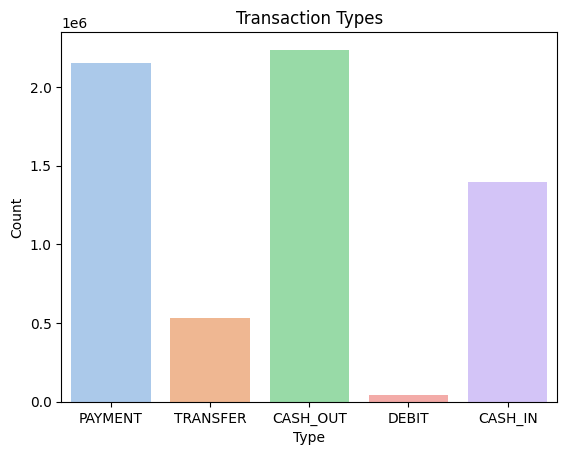

In [8]:
sns.countplot(x="type", data=df, palette="pastel")
plt.title("Transaction Types")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


# Fraud Rate by Transaction Type

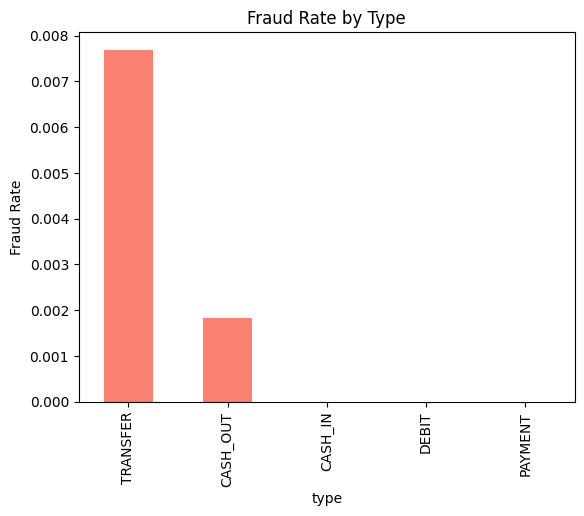

In [9]:
froud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
froud_by_type.plot(kind="bar", title="Fraud Rate by Type", color="salmon")
plt.ylabel("Fraud Rate")
plt.show()


In [13]:
df["amount"].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int32

# Transaction Amount Distribution (Log Scale)

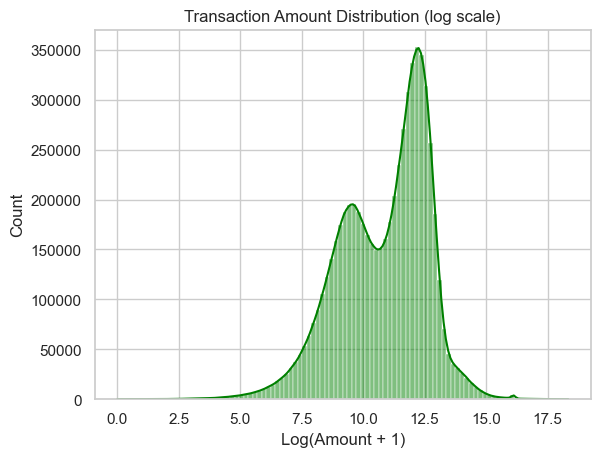

In [14]:
sns.histplot(np.log1p(df["amount"]), bins=100, kde= True, color="green")
plt.title("Transaction Amount Distribution (log scale)")
plt.xlabel("Log(Amount + 1)")
plt.show()

#  Boxplot – Amount vs isFraud (Filtered Under 50K)

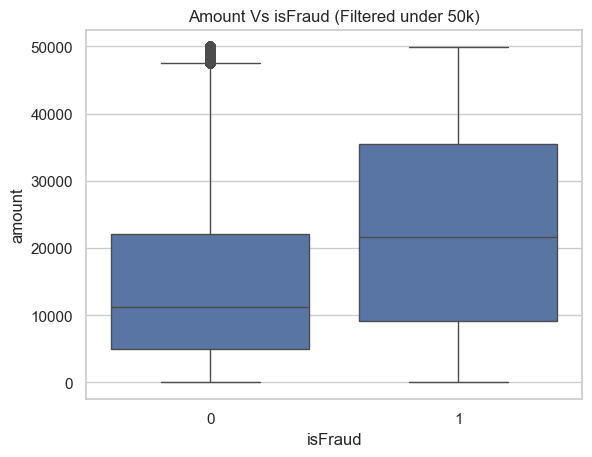

In [16]:
sns.boxplot(data=df[df["amount"] < 50000], x = "isFraud", y="amount")
plt.title("Amount Vs isFraud (Filtered under 50k)")
plt.show()

In [18]:
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]


In [19]:
(df["balanceDiffOrig"] <0).sum()

1399253

In [20]:
(df["balanceDiffDest"] <0).sum()

1238864

In [21]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0


# Fraud Over Time

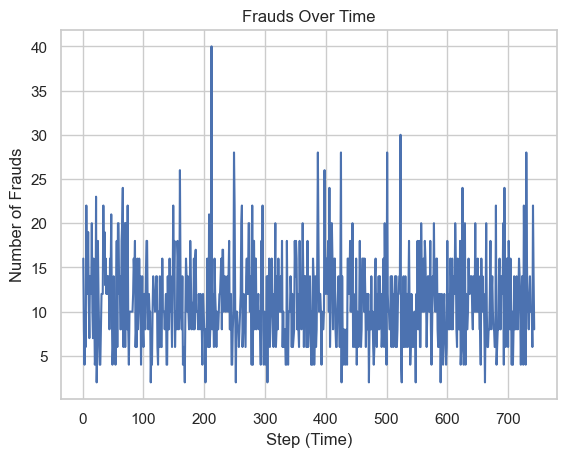

In [22]:
frauds_per_step = df[df["isFraud"] == 1]["step"].value_counts().sort_index()
plt.plot(frauds_per_step.index, frauds_per_step.values, label="Frauds per Step")
plt.xlabel("Step (Time)")
plt.ylabel("Number of Frauds")
plt.title("Frauds Over Time")
plt.grid(True)
plt.show()

In [23]:
df.drop(columns="step",inplace=True)

In [24]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,-21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


# Top Senders & Receivers

In [11]:
print("Top Senders:\n", df["nameOrig"].value_counts().head(10))
print("Top Receivers:\n", df["nameDest"].value_counts().head(10))


Top Senders:
 nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64
Top Receivers:
 nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64


# Fraud Users (Top Sources of Fraud)


In [13]:
print("Top Fraud Senders:\n", df[df["isFraud"] == 1]["nameOrig"].value_counts().head(10))


Top Fraud Senders:
 nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64


# Fraud Distribution in TRANSFER & CASH_OUT

In [15]:
print("Top Fraud Senders:\n", df[df["isFraud"] == 1]["nameOrig"].value_counts().head(10))


Top Fraud Senders:
 nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64


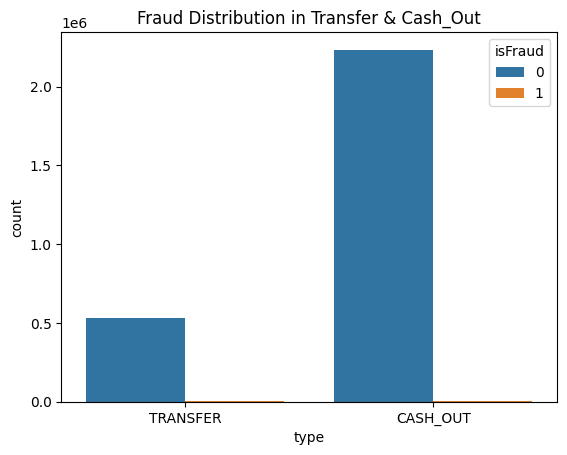

In [16]:
# Visualize fraud distribution in 'TRANSFER' and 'CASH_OUT'
import seaborn as sns
sns.countplot(data=fraud_types, x="type", hue="isFraud")
plt.title("Fraud Distribution in Transfer & Cash_Out")
plt.show()

# Correlation Matrix

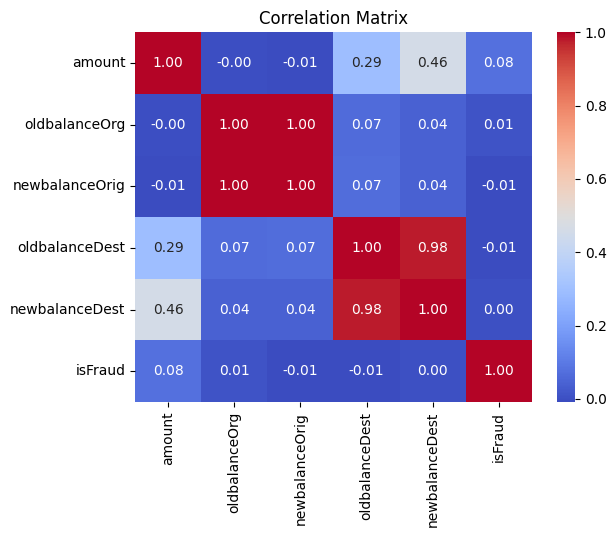

In [19]:
corr = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isFraud"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [18]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


# Fraud C ases with Zero Balance After Transfer

In [20]:
zero_after_transfer = df[
    (df["oldbalanceOrg"] > 0) &
    (df["newbalanceOrig"] == 0 ) &
    (df["type"].isin(["TRANSFER", "CASH_OUT"]))
]
print(zero_after_transfer.head())


    step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2      1  TRANSFER     181.00  C1305486145          181.0             0.0   
3      1  CASH_OUT     181.00   C840083671          181.0             0.0   
15     1  CASH_OUT  229133.94   C905080434        15325.0             0.0   
19     1  TRANSFER  215310.30  C1670993182          705.0             0.0   
24     1  TRANSFER  311685.89  C1984094095        10835.0             0.0   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2    C553264065             0.0            0.00        1               0  
3     C38997010         21182.0            0.00        1               0  
15   C476402209          5083.0        51513.44        0               0  
19  C1100439041         22425.0            0.00        0               0  
24   C932583850          6267.0      2719172.89        0               0  


# Machine Learning Model (Random Forest Pipeline)

In [27]:
# ✅ Create custom balance difference features
df["balanceDiffOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["balanceDiffDest"] = df["newbalanceDest"] - df["oldbalanceDest"]
X = df.drop('isFraud', axis=1)
y = df['isFraud']


# Prepare Dataset

In [28]:
df_model = df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)
X = df_model.drop("isFraud", axis=1)
y = df_model["isFraud"]


# Feature Types

In [29]:
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig',
                    'oldbalanceDest', 'newbalanceDest', 'balanceDiffOrig', 'balanceDiffDest']
categorical_features = ['type']


# Preprocessing + Classifier Pipeline

In [30]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])


# Train-Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# Train Model

In [ ]:
pipeline.fit(X_train, y_train)


In [60]:
pipeline.fit(x_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

# Confusion Matrix

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, display_labels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.show()


In [64]:
confusion_matrix(y_test,y_pred)

array([[1805962,  100360],
       [    167,    2297]], dtype=int64)

# Save model

In [ ]:
joblib.dump(pipeline, "fraud_detection_pipeline.pkl")


In [66]:
import joblib
joblib.dump(pipeline,"fraud_detection_pipeline.pkl")

['fraud_detection_pipeline.pkl']

# Conclusion


This project focused on detecting fraudulent transactions in a dataset of financial transactions using data analysis and machine learning techniques.

Built using Pandas, Seaborn, Random Forest, and Sklearn Pipelines

Performed EDA, correlation analysis, and engineered features like balanceDiffOrig

Achieved high accuracy and class balance using class weighting and stratified split

Deployed a pipeline that preprocesses numeric & categorical features automatically

Saved the final trained model for real-time fraud prediction

